In [164]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels.formula.api as smf 
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from arch.univariate import ZeroMean, GARCH, Normal
from statsmodels.tsa.stattools import adfuller
from sklearn import linear_model
from statsmodels.graphics.tsaplots import plot_predict
from pandas import datetime
from matplotlib import pyplot
import math
import statsmodels.tsa.api as smt
from scipy import stats
import scipy
%matplotlib inline
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

import yfinance as yf

In [165]:
#Download the data

SP500 = yf.download("^GSPC", start = '2012-6-17', end = '2022-6-18')
BAC = yf.download("BAC", start = '2012-6-17', end = '2022-6-18')



SP500 = SP500.drop(columns = ['Open', 'High', 'Low', 'Close', 'Volume'], axis=1)
BAC = BAC.drop(columns = ['Open', 'High', 'Low', 'Close', 'Volume'], axis=1)
SP500 = SP500.reset_index()
BAC = BAC.reset_index()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [73]:
BAC

,Date,Adj Close
0,2012-06-18,6.661012
1,2012-06-19,6.961442
2,2012-06-20,6.987195
3,2012-06-21,6.712515
4,2012-06-22,6.815518
...,...,...
2513,2022-06-13,32.020000
2514,2022-06-14,31.459999
2515,2022-06-15,32.049999
2516,2022-06-16,31.850000


In [166]:
#Transform the Adj Close into Log Returns 

SP500['SnP500_Log_Return'] = 100 * np.log(SP500['Adj Close'] / SP500['Adj Close'].shift(1))
SP500 = SP500.dropna()

BAC['BAC_Log_Return'] = 100 * np.log(BAC['Adj Close'] / BAC['Adj Close'].shift(1))
BAC = BAC.dropna()

In [75]:
len(BAC)

2517

In [167]:
#In Sample 
in_sample_SP500 = SP500.loc[:1936]
in_sample_BAC = BAC.loc[:1936]

#Evaluation
evaluation_SP500 = SP500.loc[1937:]
evaluation_BAC = BAC.loc[1937:]

In [78]:
evaluation_SP500.tail()

,Date,Adj Close,SnP500_Log_Return
2513,2022-06-13,3749.629883,-3.953993
2514,2022-06-14,3735.479980,-0.378082
2515,2022-06-15,3789.989990,1.448706
2516,2022-06-16,3666.770020,-3.305221
2517,2022-06-17,3674.840088,0.219845


In [70]:
#Split Data into 'In Sample' and 'Evaluation' sets 

#In Sample 
in_sample_SP500 = SP500.loc[:'2020-2-28']
in_sample_BAC = BAC.loc[:'2020-2-28']

#Evaluation
evaluation_SP500 = SP500.loc['2020-3-1':]
evaluation_BAC = BAC.loc['2020-3-1':]
#evaluation_BAC.tail()

In [6]:
print(len(evaluation_SP500))

581


# Question 1A

Naive Model 

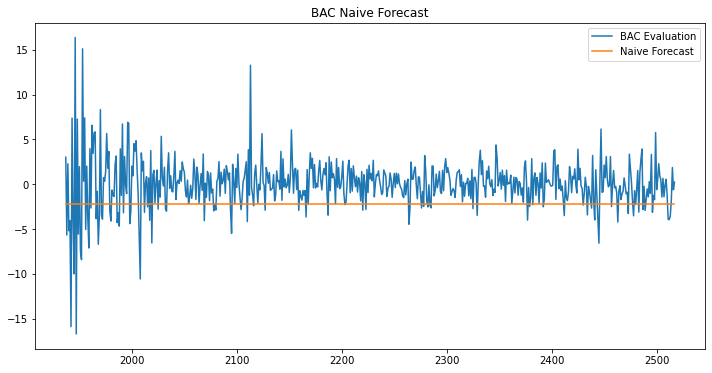

In [79]:
in_sample_array = np.array(in_sample_BAC['BAC_Log_Return'])
y_hat = evaluation_BAC.copy()
y_hat["Naive Forecast"] = in_sample_array[len(in_sample_array) - 1]
plt.figure(figsize = (12,6))
plt.plot(evaluation_BAC['BAC_Log_Return'], label = 'BAC Evaluation')
plt.plot(y_hat['Naive Forecast'], label = 'Naive Forecast')
plt.legend(loc = 'best')
plt.title("BAC Naive Forecast")
plt.show()

In [80]:
#Calculate the RMSFE and RMAFE values for Naive Model 

#RMSE
MSE = mean_squared_error(evaluation_BAC['BAC_Log_Return'], y_hat['Naive Forecast'])
RMSFE = math.sqrt(MSE)

#RMAE
MAE = mean_absolute_error(evaluation_BAC['BAC_Log_Return'], y_hat['Naive Forecast'])
RMAFE = math.sqrt(MAE)

print("Root Mean Square Forecast Error: " + str(RMSFE))
print("Root Mean Absolute Forecast Error: " + str(RMAFE))

Root Mean Square Forecast Error: 3.552014288770376
Root Mean Absolute Forecast Error: 1.6677284465606197


Reg-AR(1) Model 

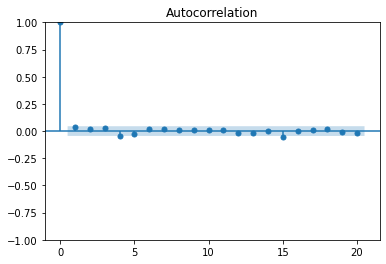

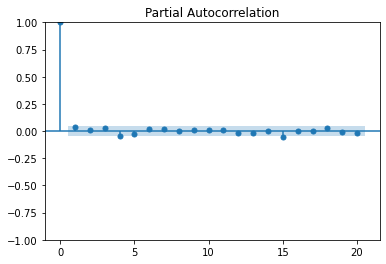

In [81]:
#ACF + PACF Plot of the Data 

plot_acf(in_sample_BAC['BAC_Log_Return'], lags = 20)
plot_pacf(in_sample_BAC['BAC_Log_Return'], lags = 20)
plt.show()


#We can see that there is 1 signifcant spike in the ACF and PACF plot indicating a AR(1) model 

In [162]:
#merge data sets 
#capm = pd.merge(in_sample_BAC, in_sample_SP500, on = 'Date', how = 'left')
#capm = pd.merge(capm, risk_free, on = 'Date', how = 'left')


#merge both in sample data 
regAR1_in_sample = pd.merge(in_sample_BAC, in_sample_SP500, on = 'Date', how = 'left').dropna()
regAR1_in_sample = regAR1_in_sample.rename(columns = {'Adj Close_x' : 'BAC Adj Close'})
regAR1_in_sample = regAR1_in_sample.rename(columns = {'Adj Close_y' : 'SP500 Adj Close'})
#regAR1_in_sample = regAR1_in_sample.drop(columns = ['Adj Close_x', 'Adj Close_y'])
#regAR1_in_sample.dropna()



regAR1_evaluation = pd.merge(evaluation_BAC, evaluation_SP500, on = 'Date', how = 'left').dropna()
regAR1_evaluation = regAR1_evaluation.rename(columns = {'Adj Close_x' : 'BAC Adj Close'})
regAR1_evaluation = regAR1_evaluation.rename(columns = {'Adj Close_y' : 'SP500 Adj Close'})
#regAR1_evaluation = regAR1_evaluation.drop(columns = ['Adj Close_x', 'Adj Close_y'])
#regAR1_evaluation.dropna()

regAR1_in_sample



,Date,BAC Adj Close,BAC_Log_Return,SP500 Adj Close,SnP500_Log_Return
0,2012-06-19,6.961442,4.411512,1357.979980,0.976783
1,2012-06-20,6.987195,0.369255,1355.689941,-0.168778
2,2012-06-21,6.712515,-4.010537,1325.510010,-2.251321
3,2012-06-22,6.815518,1.522838,1335.020020,0.714899
4,2012-06-25,6.523670,-4.376507,1313.719971,-1.608350
...,...,...,...,...,...
1931,2020-02-24,30.942713,-4.860113,3225.889893,-3.408808
1932,2020-02-25,29.382818,-5.172743,3128.209961,-3.074790
1933,2020-02-26,28.957390,-1.458466,3116.389893,-0.378570
1934,2020-02-27,27.539303,-5.021126,2978.760010,-4.516814


In [83]:
regAR1_in_sample['BAC_Lag_Return'] = regAR1_in_sample['BAC_Log_Return'].shift()
regAR1_evaluation['BAC_Lag_Return'] = regAR1_evaluation['BAC_Log_Return'].shift()

regAR1_in_sample['SnP500_Lag_Return'] = regAR1_in_sample['SnP500_Log_Return'].shift()
regAR1_evaluation['SnP500_Lag_Return'] = regAR1_evaluation['SnP500_Log_Return'].shift()

regAR1_in_sample = regAR1_in_sample.dropna()
regAR1_evaluation = regAR1_evaluation.dropna()

In [12]:
len(regAR1_in_sample)

1935

In [13]:
len(regAR1_evaluation['SnP500_Lag_Return'])

580

In [84]:
#build model 

#ar1 = ARIMA(regAR1_in_sample['BAC_Log_Return'], exog=regAR1_evaluation['SnP500_Lag_Return'], order = (1,0,0))
#results = ar1.fit()
#print(results.summary())

regAR_1 = ARIMA(endog = regAR1_in_sample['BAC_Log_Return'], exog = regAR1_in_sample['SnP500_Lag_Return'], order = (1,0,0))
reg_results = regAR_1.fit()
print(reg_results.summary())


                               SARIMAX Results                                
Dep. Variable:         BAC_Log_Return   No. Observations:                 1935
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -3674.335
Date:                Tue, 09 Aug 2022   AIC                           7356.671
Time:                        14:18:25   BIC                           7378.942
Sample:                             0   HQIC                          7364.862
                               - 1935                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0707      0.039      1.818      0.069      -0.006       0.147
SnP500_Lag_Return    -0.0194      0.052     -0.372      0.710      -0.122       0.083
ar.L1                 0.

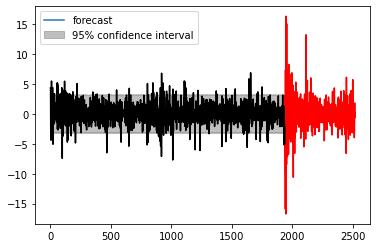

In [88]:
reg_pred1 = plot_predict(reg_results, 1, 1930, exog = regAR1_in_sample['SnP500_Lag_Return'], dynamic = False)
plt.plot(evaluation_BAC['BAC_Log_Return'], color = 'red')
plt.plot(in_sample_BAC['BAC_Log_Return'], color = 'black')



CAPM Model 

# Question 1B

In [168]:
#GARCH(1,1)

model_1 = arch_model(in_sample_BAC['BAC_Log_Return'], mean = 'Constant', vol = 'GARCH', p = 1, q = 1)
garch11 = model_1.fit(disp = 'off')
garch11

                     Constant Mean - GARCH Model Results                      
Dep. Variable:         BAC_Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3610.63
Distribution:                  Normal   AIC:                           7229.27
Method:            Maximum Likelihood   BIC:                           7251.54
                                        No. Observations:                 1936
Date:                Thu, Aug 11 2022   Df Residuals:                     1935
Time:                        15:11:59   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0988  3.358e-02      2.944  3.244e-03 [3.303e-0

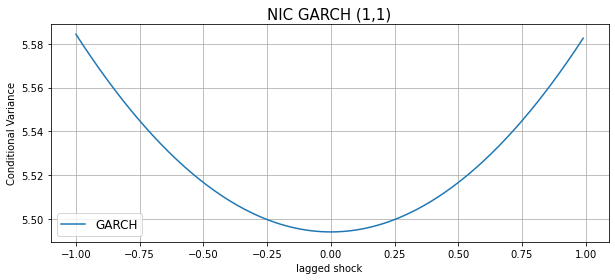

In [22]:
#NIC for GARCH(1,1)

omega_1 = garch11.params['omega']
alpha_1 = garch11.params['alpha[1]']
beta_1 = garch11.params['beta[1]']

#forecasting variance
forecast_1 = garch11.forecast()
var = forecast_1.residual_variance.tail(1).values
#forecasting lag_residuals
lag_resid_array = np.arange(-1,1,0.01)
lag_resid = pd.DataFrame(lag_resid_array)
#forecasting conditional variance
cond_var_1 = omega_1 + beta_1*var + alpha_1*lag_resid**2
#NIC GARCH Plot
plt.figure(figsize=(10,4))
plt.plot(lag_resid.values,cond_var_1.values, label='GARCH')
plt.title('NIC GARCH (1,1)', size=15)
plt.legend(loc='best', fontsize='large')
plt.ylabel('Conditional Variance')
plt.xlabel('lagged shock')
plt.grid(True)
plt.show()


In [103]:
#GJR-GARCH(1,1)

model_2 = arch_model(in_sample_BAC['BAC_Log_Return'], mean = 'Constant', p = 1, o = 1, q = 1, vol = 'GARCH')
gjr_garch11 = model_2.fit(disp = 'off')
print(gjr_garch11.summary())

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:         BAC_Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -3597.70
Distribution:                  Normal   AIC:                           7205.40
Method:            Maximum Likelihood   BIC:                           7233.25
                                        No. Observations:                 1936
Date:                Tue, Aug 09 2022   Df Residuals:                     1935
Time:                        16:30:25   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0754  3.332e-02      2.264  2.360e-02 [1.012e-0

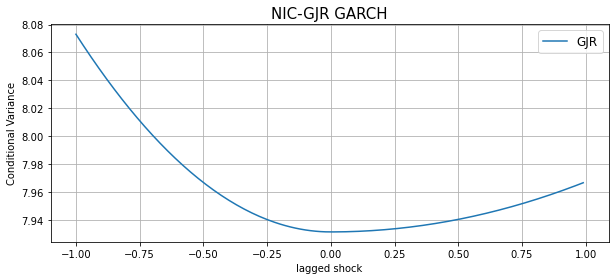

In [24]:
#NIC GJR-GARCH(1,1)

omega_gjr = gjr_garch11.params['omega']
alpha_gjr = gjr_garch11.params['alpha[1]']
beta_gjr = gjr_garch11.params['beta[1]']
gamma_gjr = gjr_garch11.params['gamma[1]']

#Forecast variance
forecast_gjr = gjr_garch11.forecast()
var =forecast_gjr.residual_variance.tail(1).values

#Forecast the lagged shocks
lag_resid_minus =pd.DataFrame(np.arange(-1,0,0.01))
lag_resid_plus = pd.DataFrame(np.arange(0.01,1,0.01))

#forecasting the conditional variance for lagged negative and positive shocks
cond_var_gjr_minus = omega_gjr + (beta_gjr*var) + (alpha_gjr*(lag_resid_minus**2)) + (gamma_gjr*(lag_resid_minus**2))
cond_var_gjr_plus = omega_gjr + beta_gjr * var + (alpha_gjr*(lag_resid_plus**2))

#merge two sets of conditional variances and lagged shocks into one column
cond_var_gjr = cond_var_gjr_minus.append(cond_var_gjr_plus,ignore_index = True)
lag_resid = lag_resid_minus.append(lag_resid_plus,ignore_index = True)

#NIC of GJR-GARCH plot
plt.figure(figsize = (10,4))
plt.plot(lag_resid.values,cond_var_gjr.values, label ='GJR')
plt.title('NIC-GJR GARCH', size = 15)
plt.legend(loc='best', fontsize = 'large')
plt.ylabel('Conditional Variance')
plt.xlabel('lagged shock')
plt.grid(True)
plt.show()


In [148]:
#EGARCH(1,0) 

model_3 = arch_model(in_sample_BAC['BAC_Log_Return'], mean = 'Constant', vol = 'EGARCH', p = 1, o = 0, q = 0)
egarch10 = model_3.fit(disp = 'off')
egarch10

                     Constant Mean - EARCH Model Results                      
Dep. Variable:         BAC_Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      EARCH   Log-Likelihood:               -3652.87
Distribution:                  Normal   AIC:                           7311.74
Method:            Maximum Likelihood   BIC:                           7328.45
                                        No. Observations:                 1936
Date:                Tue, Aug 09 2022   Df Residuals:                     1935
Time:                        21:02:24   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0805  3.541e-02      2.273  2.306e-02 [1.107e-0

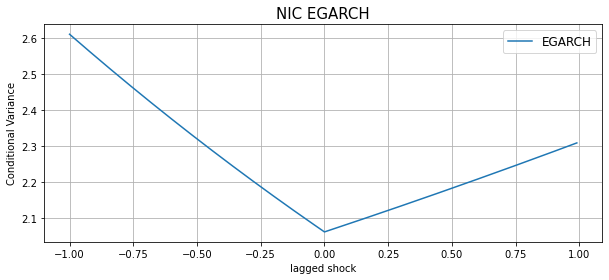

In [151]:
# NIC EGARCH(1,0)

#Retrieving the parameters from EGARCH
omega = egarch10.params['omega']
alpha = egarch10.params['alpha[1]']

#forecasting the variance
forecast = egarch10.forecast()
variance = forecast.residual_variance.tail(1).values
#forecasting the lag residuals
lag_resid_array =n p.arange(-1,1,0.01)
lag_resid = pd.DataFrame(lag_resid_array)

#forecasting the v_t and absolute v_t
v_t = lag_resid/((variance)**0.5)
err = np.abs(lag_resid)
l_cond_var = omega + gamma*v_t + alpha*(np.abs(v_t) - np.sqrt(2 / math.pi))
cond_var = np.exp(l_cond_var)

#NIC EGARCH Plot
plt.figure(figsize = (10,5))
plt.plot(lag_resid.values,cond_var.values, label='EGARCH')
plt.title('NIC EGARCH', size=15)
plt.legend(loc = 'best', fontsize='large')
plt.ylabel('Conditional Variance')
plt.xlabel('lagged shock')
plt.grid(True)
plt.show()


Volitility Forecast

In [101]:
garch_model = arch_model(evaluation_BAC['BAC_Log_Return'], mean = 'zero', vol = 'GARCH', p = 1, q = 1)
garch11 = garch_model.fit(disp = 'off')
garch11

                       Zero Mean - GARCH Model Results                        
Dep. Variable:         BAC_Log_Return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.002
Vol Model:                      GARCH   Log-Likelihood:               -1282.45
Distribution:                  Normal   AIC:                           2570.91
Method:            Maximum Likelihood   BIC:                           2584.00
                                        No. Observations:                  581
Date:                Tue, Aug 09 2022   Df Residuals:                      581
Time:                        16:30:03   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.1583      0.118      1.336      0.181 [-7.38

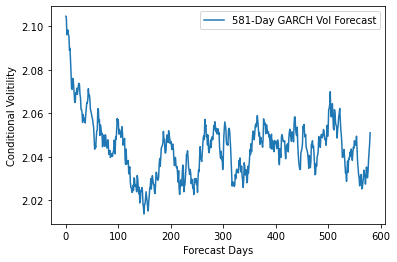

In [104]:
#Forecast variance GARCH(1,1)
forecasts = garch11.forecast(reindex = False)


#forecast conditional variancve 
sim_forecasts = garch11.forecast(horizon = 581, reindex = False, method = 'simulation')
sim_var = simG_forecasts.residual_variance.dropna()
sim_vol = simG_var**0.5


dvg = np.array(simG_vol.values)
dv = pd.DataFrame(dvg.flatten(), columns = ['GARCH_volitility'])


#plot the variance
ax = dv.GARCH_volitility.plot(label = '581-Day GARCH Vol Forecast')
ax.set_xlabel('Forecast Days')
ax.set_ylabel('Conditional Volitility')
plt.legend(title = '581 Day Vol Forecast')
plt.legend()
plt.show()

In [169]:
tmp = data['BAC_Log_Return'].expanding(min_periods = 2).sum()
plt.plot(tmp)
dv.GARCH_volitility.plot(label = '581-Day GARCH Vol Forecast')

NameError: name 'data' is not defined

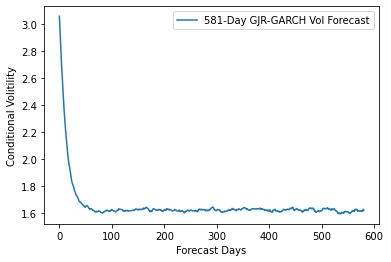

In [109]:
#Forecast GJR-GARCH(1,1) model 

forecasts = gjr_garch11.forecast(reindex = 'False')

sim_forecasts = gjr_garch11.forecast(horizon = 581, reindex = False, method = 'simulation')
sim_var = simG_forecasts.residual_variance.dropna()
sim_vol = simG_var**0.5
#simG_vol

dvg = np.array(simG_vol.values)
dv = pd.DataFrame(dvg.flatten(), columns = ['GJRGARCH_volitility'])


#plot the variance
ax = dv.GJRGARCH_volitility.plot(label = '581-Day GJR-GARCH Vol Forecast')
ax.set_xlabel('Forecast Days')
ax.set_ylabel('Conditional Volitility')
plt.legend(title = '581 Day Vol Forecast')
plt.legend()
plt.show()

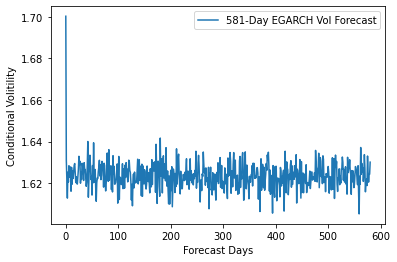

In [110]:
#Forecast EGARCH(1,0) model 

forecasts = egarch10.forecast(reindex = 'False')

sim_forecasts = egarch10.forecast(horizon = 581, reindex = False, method = 'simulation')
sim_var = simG_forecasts.residual_variance.dropna()
sim_vol = simG_var**0.5
#simG_vol

dvg = np.array(simG_vol.values)
dv = pd.DataFrame(dvg.flatten(), columns = ['EGARCH_volitility'])


#plot the variance
ax = dv.EGARCH_volitility.plot(label = '581-Day EGARCH Vol Forecast')
ax.set_xlabel('Forecast Days')
ax.set_ylabel('Conditional Volitility')
plt.legend(title = '581 Day Vol Forecast')
plt.legend()
plt.show()

PArt 3 of the question 

In [152]:
#GARCH(1,1)
model = arch_model(evaluation_BAC['BAC_Log_Return'], mean = 'zero', vol = 'GARCH', p = 1, q = 1)
x_1 = model.fit(disp = 'off')
x_1

                       Zero Mean - GARCH Model Results                        
Dep. Variable:         BAC_Log_Return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.002
Vol Model:                      GARCH   Log-Likelihood:               -1282.45
Distribution:                  Normal   AIC:                           2570.91
Method:            Maximum Likelihood   BIC:                           2584.00
                                        No. Observations:                  581
Date:                Tue, Aug 09 2022   Df Residuals:                      581
Time:                        21:54:28   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.1583      0.118      1.336      0.181 [-7.38

In [153]:
#change the omega and lambda value 

ewma = model.fix([0, 0.06, 0.94])
print(ewma.summary())

                           Zero Mean - GARCH Model Results                           
Dep. Variable:                BAC_Log_Return   R-squared:                          --
Mean Model:                        Zero Mean   Adj. R-squared:                     --
Vol Model:                             GARCH   Log-Likelihood:               -1292.96
Distribution:                         Normal   AIC:                           2591.92
Method:            User-specified Parameters   BIC:                           2605.01
                                               No. Observations:                  581
Date:                       Tue, Aug 09 2022                                         
Time:                               21:54:35                                         
   Volatility Model  
                 coef
---------------------
omega          0.0000
alpha[1]       0.0600
beta[1]        0.9400

Results generated with user-specified parameters.
Std. errors not available when the model is

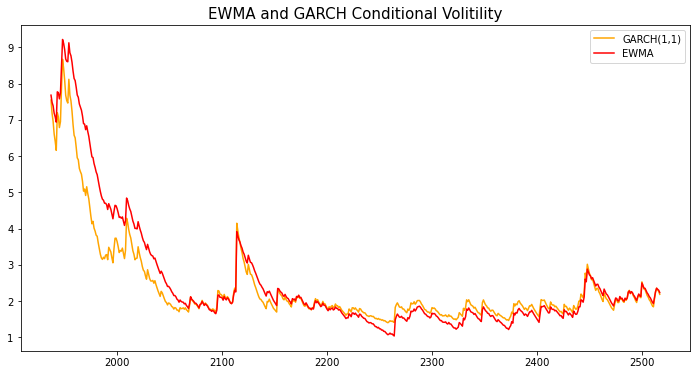

In [156]:
#get the conditional volitility for GARCH(1,1) model

con_vol1 = x_1.conditional_volatility

#get ewma conditional vol
ewma_con_vol1 = ewma.conditional_volatility

#plot the ewma curve 
con_vol1.plot(figsize = (12,6), color = 'orange', label = 'GARCH(1,1)')
ewma_con_vol1.plot(figsize = (12,6), color = 'red', label = 'EWMA')
plt.title('EWMA and GARCH Conditional Volitility', size = 15)
plt.legend(loc = 'best')
plt.show()

In [158]:
#GJR-GARCH(1,1) model

model = arch_model(evaluation_BAC['BAC_Log_Return'], mean = 'Constant', vol = 'GARCH', p = 1, o = 1, q = 1)
x_2 = model.fit(disp = 'off')
x_2

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:         BAC_Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -1275.21
Distribution:                  Normal   AIC:                           2560.42
Method:            Maximum Likelihood   BIC:                           2582.24
                                        No. Observations:                  581
Date:                Tue, Aug 09 2022   Df Residuals:                      580
Time:                        21:56:28   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.0536  8.016e-02      0.669      0.504 [ -0.103,  0.21

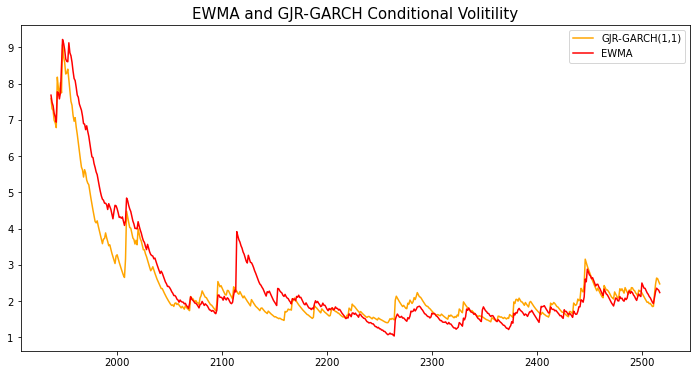

In [159]:
gjr_garch_con_vol = x_2.conditional_volatility


#plot 
gjr_garch_con_vol.plot(figsize = (12,6), color = 'orange', label = 'GJR-GARCH(1,1)')
ewma_con_vol1.plot(figsize = (12,6), color = 'red', label = 'EWMA')
plt.title('EWMA and GJR-GARCH Conditional Volitility', size = 15)
plt.legend(loc = 'best')
plt.show()

In [160]:
#EGARCH(1,0) model

model = arch_model(evaluation_BAC['BAC_Log_Return'], mean = 'Constant', vol = 'EGARCH', p = 1, o = 0, q = 0)
x_3 = model.fit(disp = 'off')
x_3

                     Constant Mean - EARCH Model Results                      
Dep. Variable:         BAC_Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      EARCH   Log-Likelihood:               -1356.56
Distribution:                  Normal   AIC:                           2719.13
Method:            Maximum Likelihood   BIC:                           2732.22
                                        No. Observations:                  581
Date:                Tue, Aug 09 2022   Df Residuals:                      580
Time:                        21:56:34   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.1051      0.100      1.049      0.294 [-9.12

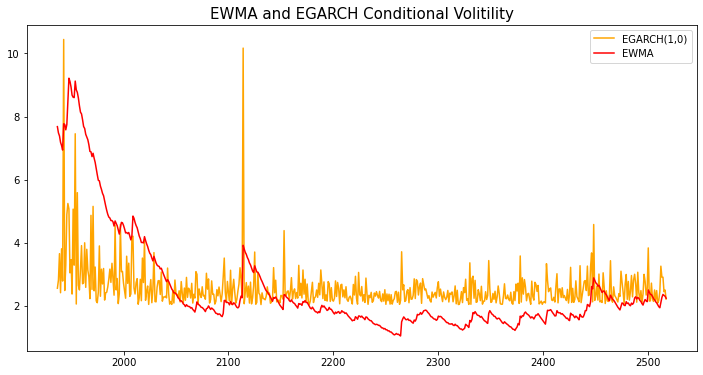

In [161]:
egarch_con_vol = x_3.conditional_volatility


#plot 
egarch_con_vol.plot(figsize = (12,6), color = 'orange', label = 'EGARCH(1,0)')
ewma_con_vol1.plot(figsize = (12,6), color = 'red', label = 'EWMA')
plt.title('EWMA and EGARCH Conditional Volitility', size = 15)
plt.legend(loc = 'best')
plt.show()

# Question 1C